In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import cartopy.crs as ccrs

In [2]:
from anemoi.models.layers.graph_provider import ProjectionGraphProvider

In [3]:
from anemoi.datasets import open_dataset

In [4]:
import torch
import einops

In [5]:
ds = open_dataset(
    cutout=[
        {"dataset": "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/hrrr.zarr", "trim_edge": [10, 11, 10, 11]},
        {"dataset": "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/gfs.zarr"},
    ],
    adjust="all",
    min_distance_km=0,
)

Dataset /pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/hrrr.zarr has missing dates
Dataset /pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/data/gfs.zarr has missing dates


In [6]:
sample = ds[:4, :, :, :]
sample = torch.Tensor(sample)

In [7]:
npzdir = "/pscratch/sd/t/timothys/nested-eagle/1.00deg-15km/mesh-gen/csmswt-trim10/truncate-full-knn36"

In [8]:
p = ProjectionGraphProvider(
    file_path=f"{npzdir}/gauss_weight-data_to_down.npz",
    row_normalize=False,
)
p_norm = ProjectionGraphProvider(
    file_path=f"{npzdir}/gauss_weight-data_to_down.npz",
    row_normalize=True,
)

Projection matrix rows do not sum to 1 (min=3.7417, max=29.3769, mean=5.5075). Consider using row_normalize=True or pre-normalized weights.


In [9]:
pinv = ProjectionGraphProvider(
    file_path=f"{npzdir}/gauss_weight-down_to_data.npz",
    row_normalize=False,
)
pinv_norm = ProjectionGraphProvider(
    file_path=f"{npzdir}/gauss_weight-down_to_data.npz",
    row_normalize=True,
)

Projection matrix rows do not sum to 1 (min=5.9999, max=6.0000, mean=5.9999). Consider using row_normalize=True or pre-normalized weights.


In [10]:
x = einops.rearrange(sample, "time features ensemble grid -> (time ensemble) grid features")

In [11]:
y = torch.stack([
    torch.sparse.mm(p.projection_matrix, x[i, ...]) for i in range(x.shape[0])
])
z = torch.stack([
    torch.sparse.mm(pinv.projection_matrix, y[i, ...]) for i in range(x.shape[0])
])

z = einops.rearrange(z, "(time ensemble) grid features -> time features ensemble grid", ensemble=1)

In [12]:
y_norm = torch.stack([
    torch.sparse.mm(p_norm.projection_matrix, x[i, ...]) for i in range(x.shape[0])
])
z_norm = torch.stack([
    torch.sparse.mm(pinv_norm.projection_matrix, y_norm[i, ...]) for i in range(x.shape[0])
])
z_norm = einops.rearrange(z_norm, "(time ensemble) grid features -> time features ensemble grid", ensemble=1)

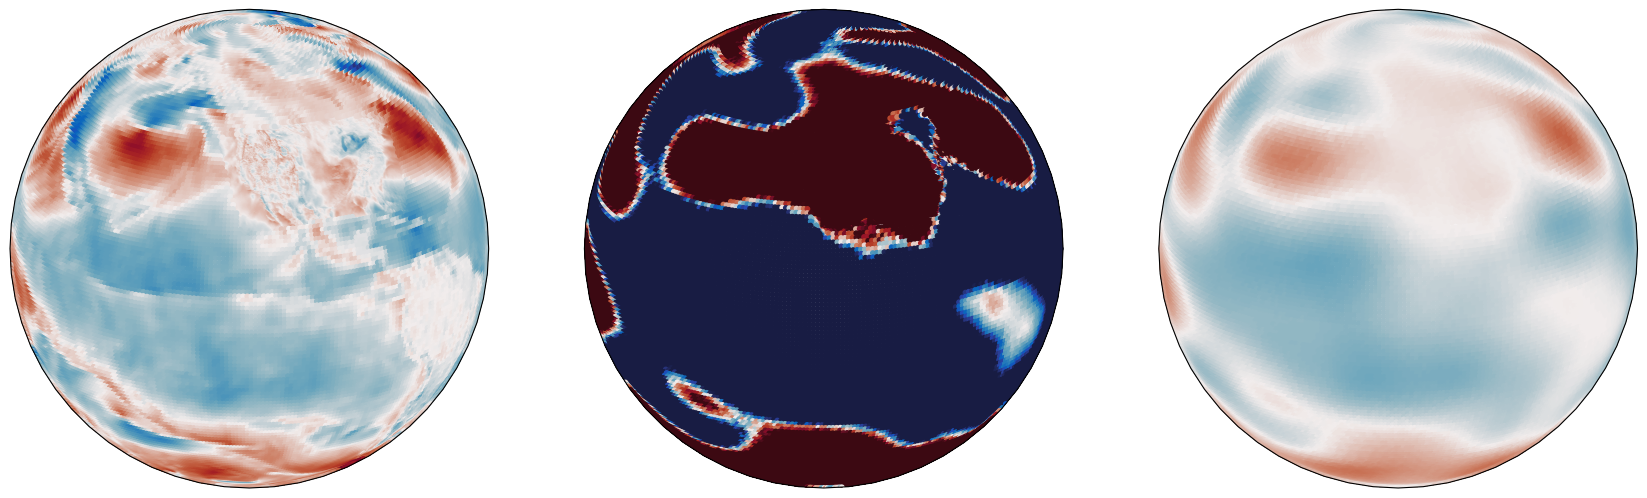

In [13]:
itime = -1
vidx = ds.variables.index("u10")
cmap = "cmo.thermal"
vmax = sample[itime,vidx,0,:].max()
vmin = sample[itime,vidx,0,:].min()

if vmax*vmin < 0:
    vmax = np.abs(np.max([vmax, vmin]))
    vmin = -vmax
    cmap = "cmo.balance"
fig, axs = plt.subplots(1, 3, figsize=(21,7), subplot_kw={"projection": ccrs.Orthographic(central_longitude=-120, central_latitude=20)})

for plotme, ax in zip([sample, z, z_norm], axs):
    for slc, s in zip(
        [slice(None, ds.grids[0]), slice(ds.grids[0], None)],
        [0.25, 10],
    ):
        ax.scatter(
            ds.longitudes[slc],
            ds.latitudes[slc],
            c=plotme[itime, vidx, 0, slc],
            transform=ccrs.PlateCarree(),
            s=s,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )

In [14]:
vmax, vmin

(22.958744, -22.958744)

In [15]:
z[itime, vidx].max(), z[itime, vidx].min()

(tensor(425.9574), tensor(-351.2953))

In [16]:
z_norm[itime, vidx].max(), z_norm[itime, vidx].min()

(tensor(12.1522), tensor(-8.4208))